# Round Trip Astrometry Test
The following piece of code performs a test of the internal precision of WCS pixel to sky coordinate conversions. After a few round trips, a surprisingly large error of order a milliarcsecond accumulates.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [2]:
from lsst.daf.persistence import Butler
from lsst.afw.geom import Point2D, SpherePoint

In [3]:
butler = Butler('/home/shared/twinkles/output_data_v2')
subset = butler.subset('calexp', filter='r') # Pick a random visit
calexp = butler.get('calexp', **subset.cache[0])

In [4]:
def roundTrip(calexp, pixel_x, pixel_y, n=11):
    wcs = calexp.getWcs()
    n = 11
    pixel_array = [Point2D(pixel_x, pixel_y)]
    sky_array = []
    separation_array = np.empty(n)
    ra_array, dec_array = np.empty(n), np.empty(n)
    for ii in range(0, n):
        sky_array.append(wcs.pixelToSky(pixel_array[-1]))
        pixel_array.append(wcs.skyToPixel(sky_array[-1]))
        separation_array[ii] = sky_array[0].separation(sky_array[-1]).asArcseconds()
        ra_array[ii] = sky_array[ii].getRa().asDegrees()
        dec_array[ii] = sky_array[ii].getDec().asDegrees()
    return separation_array, ra_array, dec_array

In [5]:
separation_array, ra_array, dec_array = roundTrip(calexp, 1000., 1000.)

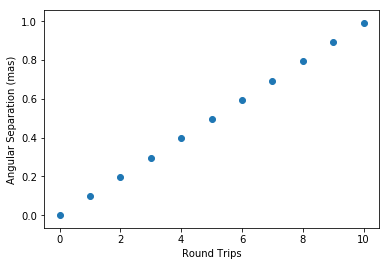

In [6]:
plt.figure()
plt.scatter(np.arange(len(separation_array)), 1000. * separation_array)
plt.xlabel('Round Trips')
plt.ylabel('Angular Separation (mas)')

(-0.002, 0.002)

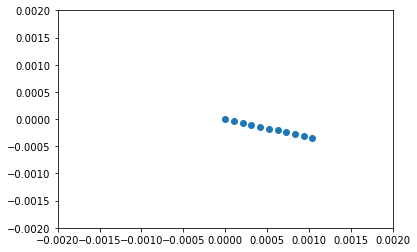

In [7]:
plt.figure()
plt.scatter(3600. * (ra_array - ra_array[0]), 3600. * (dec_array - dec_array[0]))
plt.xlim(-2.e-3, 2.e-3)
plt.ylim(-2.e-3, 2.e-3)

In [8]:
n = 10000
pixel_x_array = np.random.uniform(0, calexp.getDimensions()[0], n)
pixel_y_array = np.random.uniform(0, calexp.getDimensions()[1], n)

In [9]:
round_trip_separation_array = np.empty(n)
round_trip_ra_array = np.empty(n)
round_trip_dec_array = np.empty(n)
for ii in range(0, n):
    separation_array, ra_array, dec_array = roundTrip(calexp, pixel_x_array[ii], pixel_y_array[ii]) 
    round_trip_separation_array[ii] = separation_array[1]
    round_trip_ra_array[ii] = ra_array[0]
    round_trip_dec_array[ii] = dec_array[0]

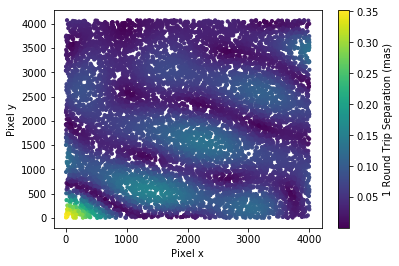

In [10]:
plt.figure()
plt.scatter(pixel_x_array, pixel_y_array, c=1000. * round_trip_separation_array, s=10)
plt.colorbar().set_label('1 Round Trip Separation (mas)')
#colorbar.set_label('')
plt.xlabel('Pixel x')
plt.ylabel('Pixel y')

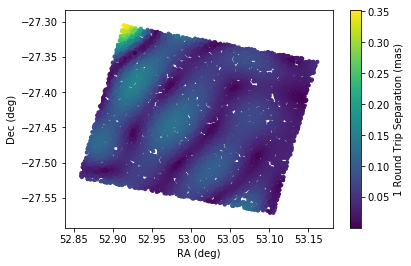

In [11]:
plt.figure()
plt.scatter(round_trip_ra_array, round_trip_dec_array, c=1000. * round_trip_separation_array, s=10)
plt.colorbar().set_label('1 Round Trip Separation (mas)')
#colorbar.set_label('')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')